In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
#import geopandas as gpd
import seaborn as sns
import numpy as np
import yaml, random, os
from sklearn.model_selection import train_test_split, GroupShuffleSplit, ShuffleSplit
from sklearn.preprocessing import StandardScaler, QuantileTransformer

import torch, sys, logging
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import TensorDataset, Dataset
from torch.utils.data.dataloader import DataLoader
from torch.nn import init

from collections import defaultdict
import tqdm, joblib

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from fmcml.data import load_data, load_splitter
from fmcml.model import DNN
import xgboost as xgb

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [3]:
def metrics(model, x, y, scaler_y = None, torch_model = False, device = "cpu", batch_size = 128):
    if torch_model:
        model.eval()
        with torch.no_grad():
            X = np.array_split(x, x.shape[0] / batch_size)
            pred = torch.cat([
                model(torch.from_numpy(_x).to(device)).cpu() for _x in X
            ])
    else:
        pred = model.predict(x)
        if len(pred.shape) == 1:
            pred = np.expand_dims(model.predict(x), 1)
    truth = y
    if scaler_y:
        pred = scaler_y.inverse_transform(pred)
        truth = scaler_y.inverse_transform(truth)
    metrics_dict = {}
    metrics_dict["truth"] = truth
    metrics_dict["pred"] = pred
    metrics_dict["rmse"] = mean_squared_error(truth, pred)**(1/2)
    metrics_dict["mae"] = np.mean(np.abs(truth-pred))
    metrics_dict["r2_score"] = r2_score(truth, pred)
    metrics_dict["mape"] = np.mean(abs(truth-pred) / (0.5*(truth+pred) + 1e-8))
    metrics_dict["diff_mean"] = np.mean(truth) - np.mean(pred)
    return metrics_dict

### Obtain CUDA device ID(s)

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

### Load the configuration

In [5]:
config = "../results/mlp_v7_2250m_site/best.yml"

In [6]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [7]:
seed = conf["seed"]
seed_everything(seed)

save_loc = conf["save_loc"]
data_loc = conf["data_loc"]
total_input_vars = []
if conf["use_nwm"]:
    total_input_vars += conf["nwm_vars"]
if conf["use_sat"]:
    total_input_vars += conf["sat_vars"]
if conf["use_static"]:
    total_input_vars += conf["static_vars"]
if conf["use_hrrr"]:
    total_input_vars += conf["hrrr_vars"]
static_vars = conf["static_vars"]
output_vars = conf["output_vars"]
verbose = conf["verbose"]
splitter = conf["split_type"]

# model config
input_size = len(total_input_vars)
middle_size = conf["model"]["middle_size"] 
output_size = len(output_vars)
dropout = conf["model"]["dropout"]
num_layers = conf["model"]["num_layers"]
#optimzer config
learning_rate = conf["optimizer"]["learning_rate"]
L2_penalty = conf["optimizer"]["L2_penalty"]
# trainer config
n_splits = conf["trainer"]["n_splits"]
batch_size = conf["trainer"]["batch_size"]
valid_batch_size = conf["trainer"]["valid_batch_size"]
lr_patience = conf["trainer"]["lr_patience"]
stopping_patience = conf["trainer"]["stopping_patience"]
epochs = conf["trainer"]["epochs"]
batches_per_epoch = conf["trainer"]["batches_per_epoch"]
training_loss = conf["trainer"]["training_loss"]
metric = conf["trainer"]["metric"]
verbose = conf["verbose"]

### Load the dataset

In [8]:
df = load_data(
    data_loc,
    verbose = verbose,
    filter_input_vars = total_input_vars, 
    filter_output_vars = output_vars
)

In [9]:
data_folds = load_splitter(
    splitter,
    df, 
    n_splits = n_splits, 
    seed = seed,
    verbose = verbose
)

In [10]:
for k_fold, (train_data, valid_data, test_data) in enumerate(data_folds):
    scaler_x = QuantileTransformer(n_quantiles=1000, random_state=seed, output_distribution = "normal") #StandardScaler()
    scaler_y = QuantileTransformer(n_quantiles=1000, random_state=seed, output_distribution = "normal") #StandardScaler()
    x_train = scaler_x.fit_transform(train_data[total_input_vars])
    x_valid = scaler_x.transform(valid_data[total_input_vars])
    x_test  = scaler_x.transform(test_data[total_input_vars])
    y_train = scaler_y.fit_transform(train_data[output_vars])
    y_valid = scaler_y.transform(valid_data[output_vars])
    y_test  = scaler_y.transform(test_data[output_vars])
    break

### Neural network model 

In [11]:
test_split = TensorDataset(
    torch.from_numpy(x_test).float(),
    torch.from_numpy(y_test).float()
)
test_loader = DataLoader(test_split, 
                          batch_size=valid_batch_size, 
                          shuffle=False, 
                          num_workers=0)

In [12]:
model = DNN(
    input_size, 
    output_size, 
    block_sizes = [middle_size for k in range(num_layers)],
    dr = [dropout for k in range(num_layers)]
).to(device)
checkpoint = torch.load(
    f"{save_loc}/mlp.pt",
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [13]:
train_metrics_mlp = metrics(model, x_train, y_train, scaler_y, torch_model = True, device = device)

/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"
/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"


In [14]:
valid_metrics_mlp = metrics(model, x_valid, y_valid, scaler_y, torch_model = True, device = device)

/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"
/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"


In [15]:
test_metrics_mlp = metrics(model, x_test, y_test, scaler_y, torch_model = True, device = device)

/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"
/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"


In [16]:
for met in ["rmse", "r2_score", "mape", "mae", "diff_mean"]:
    print(train_metrics_mlp[met], valid_metrics_mlp[met], test_metrics_mlp[met])

3.2506849486017675 3.013923948954327 3.413290055446175
0.5766058864098402 0.5657045658465143 0.5429299165055672
0.19819580635624212 0.21476427849539337 0.2141528605350169
1.7501543254802736 1.7949114488944753 1.8871488827298897
0.3333723037376952 0.14685716239802282 0.061728092809639534


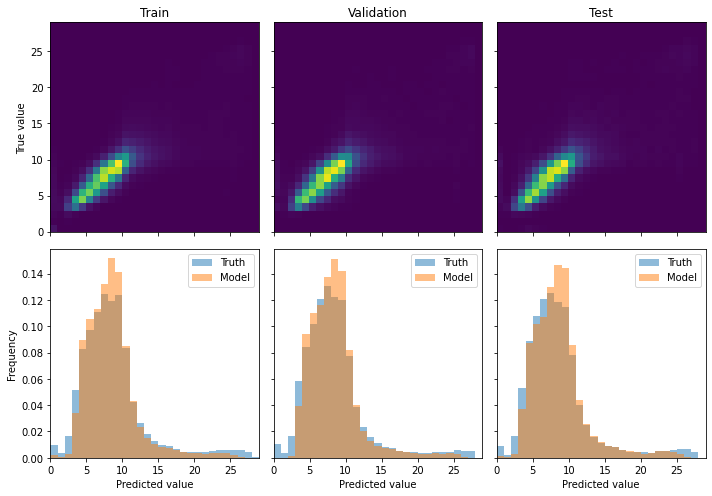

In [32]:
figsize = (10, 7)
fig, axs = plt.subplots(2, 3, figsize=figsize, sharex = "col", sharey = "row")
names = ["Train", "Validation", "Test"]
splits = [train_metrics_mlp, valid_metrics_mlp, test_metrics_mlp]
for k, (name, split) in enumerate(zip(names, splits)):
    ax1, ax2 = axs[0][k], axs[1][k]
    _ = ax1.hist2d(
        split["truth"].squeeze(-1),
        split["pred"].squeeze(-1),
        bins = np.arange(0, 30, 1)
    )
    ax1.set_title(name)
    _ = ax2.hist(split["truth"], bins = np.arange(0, 30, 1), alpha = 0.5, density = True)
    _ = ax2.hist(split["pred"], bins = np.arange(0, 30, 1), alpha = 0.5, density = True)
    ax2.legend(["Truth", "Model"])
axs[0][0].set_ylabel("True value")
axs[1][0].set_xlabel("Predicted value")
axs[1][1].set_xlabel("Predicted value")
axs[1][2].set_xlabel("Predicted value")
axs[1][0].set_ylabel("Frequency")
plt.tight_layout()

### XGBoost

In [5]:
import xgboost as xgb

In [26]:
config = "../results/xgb_v7_2250m_site/best.yml"

In [27]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [28]:
seed = conf["seed"]
seed_everything(seed)

save_loc = conf["save_loc"]
data_loc = conf["data_loc"]
total_input_vars = []
if conf["use_nwm"]:
    total_input_vars += conf["nwm_vars"]
if conf["use_sat"]:
    total_input_vars += conf["sat_vars"]
if conf["use_static"]:
    total_input_vars += conf["static_vars"]
if conf["use_hrrr"]:
    total_input_vars += conf["hrrr_vars"]
static_vars = conf["static_vars"]
output_vars = conf["output_vars"]
verbose = conf["verbose"]
splitter = conf["split_type"]

# model config
n_splits = conf["model"]["n_splits"]
objective = conf["model"]["objective"]
learning_rate = conf["model"]["learning_rate"]
n_estimators = conf["model"]["n_estimators"]
max_depth = conf["model"]["max_depth"]
n_jobs = conf["model"]["n_jobs"]
colsample_bytree = conf["model"]["colsample_bytree"]
gamma = conf["model"]["gamma"]
learning_rate = conf["model"]["learning_rate"]
max_depth = conf["model"]["max_depth"]
subsample = conf["model"]["subsample"]
metric = conf["model"]["metric"]

In [30]:
df = load_data(
    data_loc,
    verbose = verbose,
    filter_input_vars = total_input_vars, 
    filter_output_vars = output_vars
)

In [31]:
data_folds = load_splitter(
    splitter,
    df, 
    n_splits = n_splits, 
    seed = seed,
    verbose = verbose
)

In [32]:
for k_fold, (train_data, valid_data, test_data) in enumerate(data_folds):
    scaler_x = QuantileTransformer(n_quantiles=1000, random_state=seed, output_distribution = "normal") #StandardScaler()
    scaler_y = QuantileTransformer(n_quantiles=1000, random_state=seed, output_distribution = "normal") #StandardScaler()
    x_train = scaler_x.fit_transform(train_data[total_input_vars])
    x_valid = scaler_x.transform(valid_data[total_input_vars])
    x_test  = scaler_x.transform(test_data[total_input_vars])
    y_train = scaler_y.fit_transform(train_data[output_vars])
    y_valid = scaler_y.transform(valid_data[output_vars])
    y_test  = scaler_y.transform(test_data[output_vars])
    break

In [33]:
with open(os.path.join(save_loc, "model_results.pkl"), "rb") as fid:
    xgb_model, results = joblib.load(fid)

In [34]:
train_metrics = metrics(xgb_model, x_train, y_train, scaler_y)

/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"
/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"


In [35]:
valid_metrics = metrics(xgb_model, x_valid, y_valid, scaler_y)

/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"
/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"


In [36]:
test_metrics = metrics(xgb_model, x_test, y_test, scaler_y)

/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"
/glade/work/schreck/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  "X does not have valid feature names, but"


In [37]:
for met in ["rmse", "r2_score", "mape", "mae", "diff_mean"]:
    print(train_metrics[met], valid_metrics[met], test_metrics[met])

3.175071871687452 3.0335689208659895 3.389315303872589
0.5960736096683097 0.560024521463319 0.5493282544169378
0.19463235 0.21451506 0.20604467
1.7054124 1.7946645 1.827379
0.450325 0.28780842 0.24807262


In [41]:
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')
sorted_features = sorted([x for x in feature_importance.items()], key = lambda x: x[1], reverse = True)

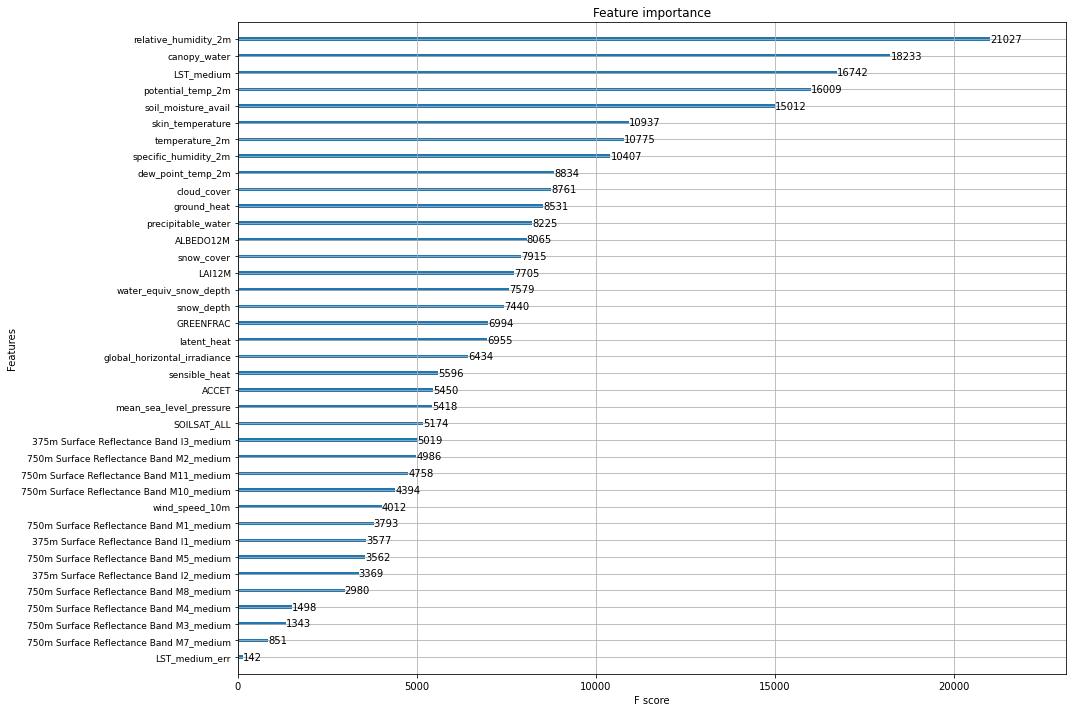

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))
feature_plot = xgb.plot_importance(xgb_model, ax=ax)
ylabels = [total_input_vars[int(x[0].strip("f"))] for x in sorted_features][::-1]
_ = ax.set_yticklabels(ylabels, fontsize = 9)
plt.tight_layout()

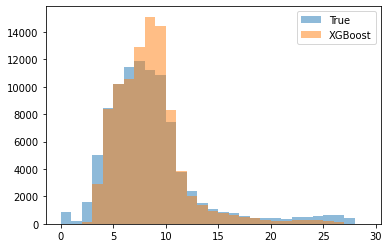

In [40]:
_ = plt.hist(test_metrics["truth"], bins = np.arange(0, 30, 1), alpha = 0.5)
_ = plt.hist(test_metrics["pred"], bins = np.arange(0, 30, 1), alpha = 0.5)
plt.legend(["True", "XGBoost"])

### Linear regression

In [80]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [81]:
regr = linear_model.LinearRegression()

In [82]:
regr.fit(x_train, y_train)

LinearRegression()

In [83]:
train_metrics_lg = metrics(regr, x_train, y_train, scaler_y)
valid_metrics_lg = metrics(regr, x_valid, y_valid, scaler_y)
test_metrics_lg = metrics(regr, x_test, y_test, scaler_y)

In [84]:
for met in ["rmse", "r2_score", "mape", "mae", "diff_mean"]:
    print(train_metrics_lg[met], valid_metrics_lg[met], test_metrics_lg[met])

2.4734303014654113 3.1557582056615328 2.7775555193251042
0.4862792769442118 0.36291816815271927 0.40432872226638006
0.20484045 0.21103133 0.22560284
1.5002398 1.6756124 1.6206456
0.24283123 0.5317297 0.21788359


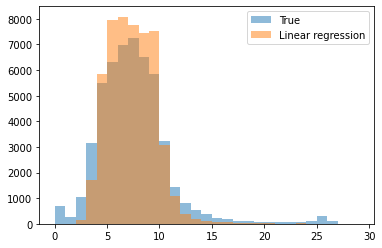

In [85]:
_ = plt.hist(test_metrics_lg["truth"], bins = np.arange(0, 30, 1), alpha = 0.5)
_ = plt.hist(test_metrics_lg["pred"], bins = np.arange(0, 30, 1), alpha = 0.5)
plt.legend(["True", "Linear regression"])